# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

### 데이터 셋 읽어오기

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
# 중복된 행을 찾음 (모든 열 값이 같은 행)
def duplicated(df_train):
    duplicate_rows_df = df_train[df_train.duplicated(keep=False)]

    # 중복된 행의 개수
    duplicate_row_count = duplicate_rows_df.shape[0]

    # 중복된 행이 있는 경우, 그 행들의 종류와 개수를 출력
    if duplicate_row_count > 0:
        # 중복된 행들의 종류와 각각의 개수를 세기
        duplicate_row_types = duplicate_rows_df.drop_duplicates()
        duplicate_row_types_count = duplicate_row_types.shape[0]

        print(f"Number of duplicate row pairs: {duplicate_row_count // 2}")
        print(f"Number of unique duplicate row types: {duplicate_row_types_count}")
        print("Unique duplicate row types:")
        print(duplicate_row_types)
    else:
        print("No duplicate rows found.")
duplicated(df_train)
df_train=df_train.drop_duplicates(keep='first', ignore_index = True)
duplicated(df_train)

Number of duplicate row pairs: 2962
Number of unique duplicate row types: 2405
Unique duplicate row types:
       bant_submit           customer_country business_unit  \
319           1.00  /East London/South Africa            AS   
321           1.00  /East London/South Africa            AS   
343           1.00        /Medellin /Colombia            AS   
1252          1.00        /Brisbane/Australia            ID   
1313          1.00                    //Ghana            ID   
...            ...                        ...           ...   
59133         0.75                   //Mexico            ID   
59261         1.00    /rio de janeiro /Brazil            AS   
59274         1.00              /Temuco/Chile            AS   
59289         0.75       /Dolnośląskie/Poland            AS   
59293         1.00            /Sląskie/Poland            AS   

       com_reg_ver_win_rate  customer_idx           customer_type  enterprise  \
319                0.040816         30958            En

In [4]:
# translations = {
#     'pénzügy': 'finance',
#     'sonstiges': 'other',
#     'altro': 'other',
#     'értékesítés': 'sales',
#     'üzemeltetés': 'operations',
#     'egyéb': 'other',
#     'mediaecomunicazione': 'media and communication',
#     'médiaéskommunikáció': 'media and communication',
#     'vendite': 'sales',
#     'program-ésprojektmenedzsment': 'program and project management',
#     'amministrativo': 'administrative',
#     'finanzen': 'finance',
#     'medienundkommunikation': 'media and communication',
#     'mediosdecomunicación': 'media and communication',
#     'operaciones': 'operations',
#     'gestióndeproyectos': 'project management',
#     'finanzas': 'finance',
#     'arte y diseño': 'art and design',
#     'radiologyprofessional': 'radiology professional',
#     'qualityassurance': 'quality assurance',
#     'profesional de cirugía': 'surgery professional',
#     'profesional de radiología': 'radiology professional',
#     'spécialisteenimageriemédicale': 'medical imaging specialist',
#     'radiology  professional': 'radiology professional',
#     'chirurgien': 'surgeon',
#     'autres': 'other',
#     'surgery professional\u200b': 'surgery professional',
#     'cirugano': 'surgeon',
#     'mediaandcommunication': 'media and communication',
#     'tierarzt': 'veterinarian',
   
#     'institute & academy': 'institute and academy',
#     'si': 'it',
    
#     'car dealership': 'car dealership',
#     'proprietário(a)': 'owner',
#     'genel müdür': 'general manager',
#     'mindenes': 'handyman',
#     'főorvos': 'chief physician','művészetésdeitgn': 'art and design',
#     'arteedeitgn': 'art and design',
#     'mediaecomunicazione': 'media and communication',
#     'médiaéskommunikáció': 'media and communication',
#     'program-ésprojektmenedzsment': 'program and project management',
#     'kreation und deitgn': 'creation and design',
#     'kreationunddeitgn': 'creation and design',
#     'medienundkommunikation': 'media and communication',
#     'mediosdecomunicación': 'media and communication',
#     'gestióndeproyectos': 'project management',
    
#     'qualityassurance': 'quality assurance',
#     'spécialisteenimageriemédicale': 'medical imaging specialist',
#     'directeur technique': 'technical director',
#     'vice preitdent': 'vice president',
#     'programm- und projektmanagement': 'program and project management',
#     'projektmenedzsment\tprogram and project management': 'project management / program and project management',
#     'művészet_és_deitgn': 'art and design',
#     'arte_e_deitgn': 'art and design',
#     'media_e_comunicazione': 'media and communication',
#     'adminisztráció': 'administration',
#     'média_és_kommunikáció': 'media and communication',
#     'program-_és_projektmenedzsment': 'program and project management',
#     'kreation und deitgn': 'creation and design',
#     'kreation_und_deitgn': 'creation and design',
#     'medien_und_kommunikation': 'media and communication',
#     'medios_de_comunicación': 'media and communication',
#     'administración': 'administration',
#     'gestión_de_proyectos': 'project management',
#     'radiology_profesitonal': 'radiology professional',
#     'spécialiste_en_imagerie_médicale': 'medical imaging specialist',
#     'medical solution  provider': 'medical solution provider',
#     'medical imaging  specialist': 'medical imaging specialist',
#     'proprietário(a)': 'owner',
   
#     'purchaitng':'purchasing'
# }
# # Make sure to convert the job titles to strings
# df_train['customer_job'] = df_train['customer_job'].astype(str)
# df_test['customer_job'] = df_test['customer_job'].astype(str)

# # Apply the translations to the 'customer_job' column
# df_train['customer_job'] = df_train['customer_job'].replace(translations, regex=False)
# df_test['customer_job'] = df_test['customer_job'].replace(translations, regex=False)

# # Check the results
# print(df_train['customer_job'].unique())
# print(df_test['customer_job'].unique())

In [5]:
# import pandas as pd
# import numpy as np

# def clean_and_map_job(job):
#     # Handle NaN values first
#     if pd.isna(job):
#         return np.nan
    
#     # Clean up the job title
#     job = job.replace('_', '').replace('-', '').replace('(', '').replace(')', '').replace('otro', 'other').replace('&','and').lower()

#     # Keyword-based category mapping with regular expressions for whole word matching
#     keywords_to_category = {
#         'information technology':'it',
#         'sale': 'sale',
#         r'\bart\b': 'art',
#         r'\bit\b': 'it',
#         'it/software': 'it',
#         'consul': 'consulting',
#         'supervisor': 'supervisor',
#         'teach': 'education',
#         'director': 'director',
#         'edu': 'education',
#         'school': 'education',
#         'design': 'artanddesign',
#         'market': 'marketing',
#         'purchas': 'purchasing',
#         'engineer': 'engineering',
#         'manager': 'manager',
        
#         'electro': 'electronics',
#         'clinic': 'healthcare',
#         'health': 'healthcare',
#         'research': 'research',
#         'project': 'project-management',
#         'military': 'military',
#         'medical': 'medical',
#         'tech': 'technology',
#         'advertis': 'advertising',
#         'manage': 'management',
#         'procurement': 'procurement',
#         'bidder': 'bidder',
#         'contractor': 'contracting',
#         'software': 'it',
#         'project-management':'management',
#         'admin': 'administration'
#     }

#     for keyword, category in keywords_to_category.items():
#         if re.search(keyword, job):
#             return category
    
#     # If no matching keyword, return 'job'
#     return job

# # Make sure to import re when you use regular expressions
# import re

# # Apply the mapping function to DataFrame columns and clean up job titles
# df_train['customer_job'] = df_train['customer_job'].apply(clean_and_map_job)
# df_test['customer_job'] = df_test['customer_job'].apply(clean_and_map_job)

# # 결과 확인
# print(df_train['customer_job'].unique())
# print(df_test['customer_job'].unique())


In [6]:
# 다 소문자화 시켜줌
def preprocess_dataframe(df):
    # 데이터프레임의 모든 문자를 소문자로 변환
    df = df.applymap(lambda x: x.lower() if type(x) == str else x)
    
    # 띄어쓰기를 '/'로 치환
    df = df.applymap(lambda x: x.replace(' ', '') if type(x) == str else x) #/없는게 더 나을듯
    df = df.applymap(lambda x: x.replace('-', '') if type(x) == str else x) #/없는게 더 나을듯
    df = df.applymap(lambda x: x.replace ( '[^ \ w \ s]', '') if type(x) == str else x)
    df = df.applymap(lambda x: x.replace('_', '') if type(x) == str else x) #/없는게 더 나을듯
    df = df.applymap(lambda x: x.replace('~', '') if type(x) == str else x) #/없는게 더 나을듯
    df = df.replace('others', 'other', inplace=False)
    return df
df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)


In [7]:
import pandas as pd
from textblob import TextBlob
from tqdm.auto import tqdm  # tqdm의 Jupyter 노트북에 최적화된 버전을 사용합니다.

tqdm.pandas()  # pandas 연산에 대한 tqdm의 진행 표시줄 활성화

# 오타 수정 함수를 TextBlob을 사용하도록 변경
def correct_typos_with_textblob(string):
    if pd.isnull(string):
        return string
    corrected_text = TextBlob(string.lower()).correct() #대문자를 다 소문자로 고친후 코드 돌림
    return str(corrected_text)

# Load the CSV files
#df_train = pd.read_csv("train.csv")  # 학습용 데이터
#df_test = pd.read_csv("submission.csv")  # 테스트 데이터(제출 파일의 데이터)
#df_train.fillna("", inplace=True)  # 결측치를 빈 문자열로 대체
#df_test.fillna("", inplace=True)  # 결측치를 빈 문자열로 대체

# '/'로 나누어진 데이터의 마지막 요소 추출 함수는 그대로 유지
def extract_last_country(value):
    return value.split('/')[-1] if pd.notnull(value) else value

# Apply the function to 'customer_country' and 'customer_country.1' columns for both dataframes
df_test['customer_country'] = df_test['customer_country'].apply(extract_last_country)
#df_test['customer_country.1'] = df_test['customer_country.1'].apply(extract_last_country)

df_train['customer_country'] = df_train['customer_country'].apply(extract_last_country)
#df_train['customer_country.1'] = df_train['customer_country.1'].apply(extract_last_country)

# # Apply the TextBlob correct_typos function to 'customer_country' and 'customer_country.1' columns
# df_test['customer_country'] = df_test['customer_country'].apply(correct_typos_with_textblob)
# #df_test['customer_country.1'] = df_test['customer_country.1'].apply(correct_typos_with_textblob)

# df_train['customer_country'] = df_train['customer_country'].apply(correct_typos_with_textblob)
# #df_train['customer_country.1'] = df_train['customer_country.1'].apply(correct_typos_with_textblob)


In [8]:
# # inplace=True 없이 사용
# df_train['customer_position'] = df_train['customer_position'].str.replace('others', 'other')
# df_test['customer_position'] = df_test['customer_position'].str.replace('others', 'other')


# df_train['product_category'] = df_train['product_category'].str.replace('others', 'other')
#df_train['product_category'] = df_train['product_category'].str.replace('_', '')
# df_test['product_category'] = df_test['product_category'].str.replace('others', 'other')
#df_test['product_category'] = df_test['product_category'].str.replace('_', '')


df_train['customer_country'] = df_train['customer_country'].str.replace('türkiye', 'turkey')
df_test['customer_country'] = df_test['customer_country'].str.replace('türkiye', 'turkey')
# df_train['customer_country'] = df_train['customer_country'].replace('us', 'unitedstates')
# df_train['customer_country'] = df_test['customer_country'].replace('us', 'unitedstates')

# #df_test['customer_country'] = df_test['customer_country'].str.replace('türkiye', 'turkey')



# df_train['inquiry_type'] = df_train['inquiry_type'].str.replace('others', 'other')
#df_train['inquiry_type'] = df_train['inquiry_type'].str.replace('_', '')
# df_test['inquiry_type'] = df_test['inquiry_type'].str.replace('others', 'other')
#df_test['inquiry_type'] = df_test['inquiry_type'].str.replace('_', '')

# # def normalize_s(cell):
# #     # cell이 문자열인지 확인
# #     if isinstance(cell, str):
# #         # 문자열의 끝이 's'로 끝나는 경우 이를 제거
# #         if cell.endswith('s'):
# #             return cell[:-1]
# #     # 문자열이 아니거나, 's'로 끝나지 않는 경우, cell을 그대로 반환
# #     return cell

# # DataFrame의 특정 컬럼에 함수를 적용하려면, apply 메서드와 lambda 함수를 사용합니다.
# #df_test['customer_job'] = df_test['customer_job'].apply(lambda x: normalize_s(x))
# #df_train['customer_job'] = df_train['customer_job'].apply(lambda x: normalize_s(x))


In [9]:

df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('then', 'than')
#df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('_', '')
#df_train['expected_timeline'] = df_train['expected_timeline'].str.replace('~', '')
# df_train['expected_timeline'] = df_train['expected_timeline'].replace('3months', '3months6months')
# df_train['expected_timeline'] = df_train['expected_timeline'].replace('lessthen6', 'lessthan6months')
# df_train['expected_timeline'] = df_train['expected_timeline'].replace('onemonth', 'lessthan3months')
# df_train['expected_timeline'] = df_train['expected_timeline'].replace('45 days', '3months6months')
# df_train['expected_timeline'] = df_train['expected_timeline'].replace('lessthan5months', '3months6months')
df_test['expected_timeline'] = df_test['expected_timeline'].str.replace('then', 'than')
#df_test['expected_timeline'] = df_test['expected_timeline'].str.replace('_', '')
#df_test['expected_timeline'] = df_test['expected_timeline'].str.replace('~', '')
# df_test['expected_timeline'] = df_test['expected_timeline'].replace('3months', '3months6months')
# df_test['expected_timeline'] = df_test['expected_timeline'].replace('lessthen6', 'lessthan6months')
# df_test['expected_timeline'] = df_test['expected_timeline'].replace('onemonth', 'lessthan3months')
# df_test['expected_timeline'] = df_test['expected_timeline'].replace('45 days', '3months6months')
# df_test['expected_timeline'] = df_test['expected_timeline'].replace('lessthan5months', '3months6months')



In [10]:
# import pandas as pd

# def map_keywords(value):
#     # 소문자로 변환하여 검사합니다 (대소문자 구분 없이)
#     value = str(value).lower()
#     if 'purchase' in value:
#         return 'purchase_related'
#     elif 'technical' in value:
#         return 'technical_related'
#     elif 'sales' in value:
#         return 'sales_related'
#     else:
#         return value  # 키워드가 없는 경우 원래 값을 유지

# def map_keywords_subarea(value):
#     # 소문자로 변환하여 검사합니다 (대소문자 구분 없이)
#     value = str(value).lower()
#     if 'air' in value:
#         return 'air_related'
    
    
# df_train['inquiry_type'] = df_train['inquiry_type'].apply(map_keywords)

# df_test['inquiry_type'] = df_test['inquiry_type'].apply(map_keywords)


# df_train['business_subarea'] = df_train['business_subarea'].apply(map_keywords_subarea)

# df_test['business_subarea'] = df_test['business_subarea'].apply(map_keywords_subarea)

In [11]:
category_columns = [
    "customer_country",
    "business_unit",
    "customer_idx",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "business_subarea",
    "business_area",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "expected_timeline",
    "response_corporate",
    "lead_owner"
]
for col in category_columns:
    # 각 값이 나타난 횟수 계산
    value_counts = df_train[col].value_counts()
    
    # 5회 미만으로 나타난 값들을 필터링
    to_replace = value_counts[value_counts < 5].index

    # 컬럼의 데이터 타입이 숫자형인지 확인 후 처리
    if np.issubdtype(df_train[col].dtype, np.number):
        df_train[col] = df_train[col].mask(df_train[col].isin(to_replace), np.nan)
    else:
        # 범주형 데이터는 'nan'로 대체
        df_train[col] = df_train[col].mask(df_train[col].isin(to_replace), np.nan)
def categorize_timeline(value):
    # 문자열이 아닌 경우 (예: NaN)
    if not isinstance(value, str):
        return value  # 원래의 값을 그대로 반환 (NaN 포함)
    
    # 문자열 내의 공백과 특수문자를 제거합니다.
    value = value.replace(" ", "").replace("_", "").lower()
    
    # 새로운 분류 기준에 따라 문자열을 매핑합니다.
    if 'lessthan3months' in value:
        return 'lessthan3months'
    elif 'morethanayear' in value:
        return 'morethanayear'
    elif '6months~9months' in value or '6months9months' in value:
        return '6months9months'
    elif '3months~6months' in value or '3months6months' in value:
        return '3months6months'
    elif '9months~1year' in value or '9months1year' in value:
        return '9months1year'
    else:
        # 이외의 경우는 분류 기준에 맞지 않으므로 'other'로 분류
        return np.nan
        
    
# 함수를 사용하여 'expected_timeline' 열을 새로운 값으로 업데이트합니다.
df_train['expected_timeline'] = df_train['expected_timeline'].apply(categorize_timeline)

# 업데이트된 데이터 프레임의 'expected_timeline' 열의 유니크한 값들을 확인합니다.
df_train['expected_timeline'].unique()

# unique_values 계산
unique_values_1 = {col: set(df_test[col].unique()) for col in df_test.columns}
unique_values_2 = {col: set(df_train[col].unique()) for col in df_train.columns}
for col in sorted(df_train.columns.intersection(df_test.columns)):
    # 모든 값을 문자열로 변환하여 정렬
    unique_values_test_sorted = sorted(map(str, unique_values_1[col]))
    unique_values_train_sorted = sorted(map(str, unique_values_2[col]))
    
    # 정렬된 유니크한 값들을 비교
    if unique_values_test_sorted != unique_values_train_sorted:
        print(f"Column: {col}")
        print(f"Unique in df_test: {unique_values_test_sorted}")
        print(f"Unique in df_train: {unique_values_train_sorted}")



Column: business_subarea
Unique in df_test: ['advertising', 'aerospace', 'agriculture', 'airline', 'apartment', 'banking', 'bookstore', 'botanicalgarden/greenhouse', 'broadcasting&media', 'busterminal', 'cardealership', 'chemicalfactory/plant', 'cinema/theater', 'clinic', 'construction', 'consulting', 'cosmetics', 'cruise', 'developer/property', 'distributioncenter', 'dormitory', 'dutyfreeshop', 'electronics&telco', 'energy', 'energystorage&saving', 'engineering', 'entertainment', 'exhibition/conventioncenter', 'f&b(foodandbeverage)', 'fashion', 'finance', 'fitness', 'gasstation', 'generalgovernmentoffice', 'generalhospital', 'healthcare', 'highereducation(college&university)', 'holdings', 'hospital', 'hotel', 'hypermarket&grocery', 'institute&academy', 'insurance', 'investment', 'it/software', 'k12kindergarten&schools', 'lawfirm', 'logistics', 'ltc(longtermcare)', 'luxury(watch/jewelryshop)', 'manufacturing', 'manufacturingfactory/plant', 'military', 'mining', 'mixeduse(multicomplex)'

In [12]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,philippines,as,0.066667,NaN,endcustomer,enterprise,NaN,NaN,NaN,...,lgeph,lessthan3months,1,0,0.003079,0.026846,corporate/office,engineering,0.0,True
1,1.0,philippines,as,0.066667,NaN,endcustomer,enterprise,12.0,NaN,NaN,...,lgeph,lessthan3months,1,0,0.003079,0.026846,corporate/office,advertising,1.0,True
2,1.0,india,as,0.088889,NaN,endcustomer,enterprise,144.0,NaN,NaN,...,lgeil,lessthan3months,1,0,0.003079,0.026846,corporate/office,construction,2.0,True
3,1.0,india,as,0.088889,NaN,endcustomer,enterprise,NaN,NaN,NaN,...,lgeil,lessthan3months,1,0,0.003079,0.026846,corporate/office,it/software,3.0,True
4,1.0,india,as,0.088889,NaN,specifier/influencer,enterprise,NaN,NaN,NaN,...,lgeil,lessthan3months,0,0,0.003079,0.026846,corporate/office,NaN,4.0,True


#### customer country NLP로 전처리후 모델에 넣으면 학습 어떻게 되는지 확인해야됨
#### 카테고리 데이터 숫자로 변환후 원핫 인코딩 진행 및 수치형 데이터 노말라이즈 진행(train기준 maxmin으로 진행)

In [13]:
# 각 DataFrame의 칼럼에 대해 NaN 값을 'nan' 문자열로 변환하는 함수
def replace_nan_with_str(dataframe, columns):
    for col in columns:
        dataframe[col] = dataframe[col].fillna('nan')
    return dataframe

# DataFrame 복사본을 만들어 원본 데이터를 보존
df_test_copy = df_test.copy()
df_train_copy = df_train.copy()

# 'nan' 문자열로 NaN 값을 대체
df_test_copy = replace_nan_with_str(df_test_copy, df_test_copy.columns)
df_train_copy = replace_nan_with_str(df_train_copy, df_train_copy.columns)

# 이제 위의 로직을 복사본 DataFrame에 적용
unique_values_1 = {col: set(df_test_copy[col].unique()) for col in df_test_copy.columns}
unique_values_2 = {col: set(df_train_copy[col].unique()) for col in df_train_copy.columns}

for col in sorted(df_train_copy.columns.intersection(df_test_copy.columns)):
    unique_values_test_sorted = sorted(map(str, unique_values_1[col]))
    unique_values_train_sorted = sorted(map(str, unique_values_2[col]))
    
    if unique_values_test_sorted != unique_values_train_sorted:
        #if (col == 'product_category') or (col == 'product_subcategory') or (col == 'product_modelname'):
        if (col == 'inquiry_type') or (col == 'customer_position') :
            print(f"Column: {col}")
            unique_value_counts_test = {value: df_test_copy[col].value_counts().get(value, 0) for value in unique_values_test_sorted}
            unique_value_counts_train = {value: df_train_copy[col].value_counts().get(value, 0) for value in unique_values_train_sorted}

            print(f"Count of unique values in df_test: {unique_value_counts_test}")
            print(f"Count of unique values in df_train: {unique_value_counts_train}")

   




for col in sorted(df_train.columns.intersection(df_test.columns)):
     if (col != 'customer_country.1')&(col != 'customer_idx'):
    
        # 모든 값을 문자열로 변환하여 정렬
        unique_values_test_sorted = sorted(map(str, unique_values_1[col]))
        unique_values_train_sorted = sorted(map(str, unique_values_2[col]))
        difference_in_test = set(unique_values_test_sorted) - set(unique_values_train_sorted)

        # unique_values_train_아니sorted에서 unique_values_test_sorted를 뺀 차집합 구하기
        difference_in_train = set(unique_values_train_sorted) - set(unique_values_test_sorted)
        print(f"Column: {col}")
        # 결과 출력
        print("name in test not in train:", difference_in_test)
        print("name in train not in test:", difference_in_train)

Column: customer_position
Count of unique values in df_test: {'academiccoordinator/postgraduateteacher(accountancy,businessstudies)/tgt(ict)': 1, 'assistantprofessor': 1, 'associate/analyst': 279, 'asstprof.': 1, 'ceo/founder': 593, 'clevelexecutive': 85, 'cofounder': 1, 'customer': 2, 'director': 343, 'directorcumfacultyatgainingapexcoachingcentre': 1, 'educator': 2, 'entrylevel': 225, 'intern': 60, 'manager': 726, 'mathandphysicsteacher': 1, 'none': 1957, 'other': 664, 'partner': 224, 'pgtchemistry': 1, 'professor': 1, 'trainee': 49, 'vicepresident': 54}
Count of unique values in df_train: {'administrative': 5, 'assistantprofessor': 7, 'associate/analyst': 2507, 'bulgaria': 7, 'cargo': 27, 'ceo/founder': 7745, 'clevelexecutive': 821, 'commercialenduser': 7, 'consultant': 22, 'decisioninfluencer': 14, 'decisionmaker': 12, 'director': 4735, 'employee': 14, 'enduser': 421, 'engineering': 9, 'entrylevel': 2126, 'government': 29, 'homeowner': 21, 'hospital': 199, 'installer': 59, 'intern'

## 2. 데이터 전처리

### 레이블 인코딩

In [14]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [15]:
# # 레이블 인코딩할 칼럼들
# label_columns = [
#     "customer_country",
#     "business_subarea",
#     "business_area",
#     "business_unit",
#     "customer_type",
#     "enterprise",
#     "customer_job",
#     "inquiry_type",
#     "product_category",
#     "product_subcategory",
#     "product_modelname",
#     "customer_country.1",
#     "customer_position",
#     "response_corporate",
#     "expected_timeline",
# ]
# category_columns = [
#     "customer_country",
#     "business_unit",
#     "customer_idx",
#     "customer_type",
#     "enterprise",
#     "customer_job",
#     "inquiry_type",
#     "business_subarea",
#     "business_area",
#     "product_category",
#     "product_subcategory",
#     "product_modelname",
#     "customer_country.1",
#     "customer_position",
#     "expected_timeline",
#     "response_corporate",
#     "lead_owner"
# ]

# label_mappings = {}

# for col in category_columns:
#     if col in df_train.columns:
#         # df_train에서의 빈도수 계산 및 5회 미만을 NaN으로 매핑
#         value_counts = df_train[col].dropna().value_counts()
#         values_to_zero = value_counts[value_counts < 5].index
#         df_train.loc[df_train[col].isin(values_to_zero), col] = np.nan

#         # 빈도수에 따라 내림차순으로 레이블 할당
#         value_counts = df_train[col].dropna().value_counts().sort_values(ascending=False)
#         new_labels = {np.nan: 0}
        
#         # 가장 빈도수가 높은 카테고리가 가장 큰 값을 가지도록 레이블 카운트 설정
#         new_label_count = len(value_counts)
#         for value in value_counts.index:
#             new_labels[value] = new_label_count
#             new_label_count -= 1  # 레이블 값을 감소시키며 할당

#         # 레이블 매핑 저장
#         label_mappings[col] = new_labels

#         # df_train에 레이블 매핑 적용
#         df_train[col] = df_train[col].map(new_labels)

# # df_test에 대한 새로운 카테고리의 빈도수 계산 및 레이블 매핑 적용
# for col, mapping in label_mappings.items():
#     if col in df_test.columns:
#         # df_test에서 각 카테고리의 빈도수 계산
#         test_value_counts = df_test[col].value_counts()

#         # df_train에서 사용된 최대 레이블 번호 확인
#         max_label = max(mapping.values())

#         # 새로운 카테고리에 대해 레이블 매핑 적용
#         new_mapping = mapping.copy()  # 기존 매핑 복사
#         for value, count in test_value_counts.items():
#             # 새로운 카테고리이고 5회 이상 나타나는 경우 새로운 레이블 할당
#             if value not in new_mapping and count >= 5:
#                 print(value)
#                 max_label += 1
#                 new_mapping[value] = max_label

#         # df_test에 새로운 레이블 매핑 적용
#         df_test[col] = df_test[col].apply(lambda x: new_mapping.get(x, 0))  # 매핑에 없는 경우 0으로 처리


In [16]:

label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
     df_all[col] = label_encoding(df_all[col])
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]
#df_train.dropna(axis=1, inplace=True)
#df_test.dropna(axis=1, inplace=True)# 레이블 인코딩할 칼럼들

#### 5회 미만 제거 및 범주형 데이터 빈도수에 맞추어 labeling

다시 학습 데이터와 제출 데이터를 분리합니다.

In [17]:
# for col in label_columns:  
#     df_train[col] = df_all.iloc[: len(df_train)][col]
#     df_test[col] = df_all.iloc[len(df_train) :][col]
# #df_train.dropna(axis=1, inplace=True)
# #df_test.dropna(axis=1, inplace=True)

### VIF 다중공선성 해결

In [18]:
from sklearn.linear_model import LinearRegression as LR
df_train.drop(['customer_country.1'],axis=1,inplace=True)
df_test.drop(['customer_country.1'],axis=1,inplace=True)
df_train.drop(['customer_idx'],axis=1,inplace=True)
df_test.drop(['customer_idx'],axis=1,inplace=True)
# df_train.drop(['ver_win_rate_x'],axis=1,inplace=True)
# df_test.drop(['ver_win_rate_x'],axis=1,inplace=True)
# df_train.drop(['business_area'],axis=1,inplace=True)
# df_test.drop(['business_area'],axis=1,inplace=True)
df_train.drop(['business_subarea'],axis=1,inplace=True)
df_test.drop(['business_subarea'],axis=1,inplace=True)
df_train.drop(['idit_strategic_ver'],axis=1,inplace=True)
df_test.drop(['idit_strategic_ver'],axis=1,inplace=True)
#df_train.drop(['it_strategic_ver'],axis=1,inplace=True)
#df_test.drop(['it_strategic_ver'],axis=1,inplace=True)
#df_train.drop(['id_strategic_ver'],axis=1,inplace=True)
#df_test.drop(['id_strategic_ver'],axis=1,inplace=True)
#df_train.drop(['product_modelname'],axis=1,inplace=True)
# df_test.drop(['product_modelname'],axis=1,inplace=True)
#df_train.drop(['product_subcategory'],axis=1,inplace=True)
#df_test.drop(['product_subcategory'],axis=1,inplace=True)

VIF_dict = dict()
df_train.fillna(0,inplace=True) # 결측치 -1로 채워봄
df_test.fillna(0,inplace=True)
for col in df_train.columns:
    model = LR().fit(df_train.drop([col], axis=1), df_train[col])
    r2 = model.score(df_train.drop([col], axis=1), df_train[col])
    VIF = 1 / max((1 - r2), 1e-9)
    VIF_dict[col] = VIF

# VIF 값이 5 이상인 열을 출력
high_VIF_columns = [col for col, vif in VIF_dict.items() if vif >= 5]
print("Columns with VIF >= 5:", high_VIF_columns)
df_train.drop(high_VIF_columns,axis=1,inplace=True)
df_test.drop(high_VIF_columns,axis=1,inplace=True)

Columns with VIF >= 5: []


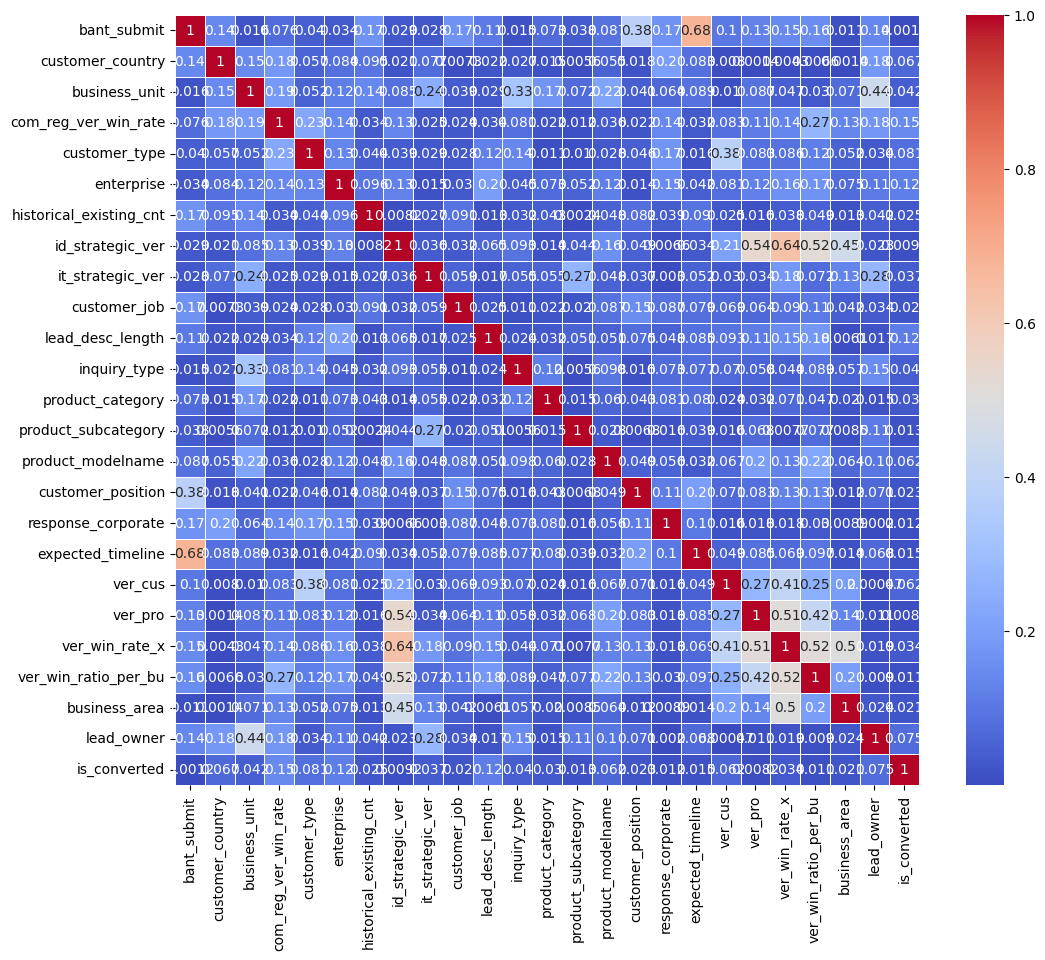

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df_train.corr()


# 상관관계 매트릭스를 히트맵으로 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(abs(correlation_matrix), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()
#df_train.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'customer_country.1'],axis=1,inplace=True)
#df_test.drop(['id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'customer_country.1'],axis=1,inplace=True)

                    Feature  Importance
20           ver_win_rate_x    0.125898
2             business_unit    0.119726
6   historical_existing_cnt    0.087137
4             customer_type    0.086629
3      com_reg_ver_win_rate    0.072802
23               lead_owner    0.061174
16       response_corporate    0.054814
10         lead_desc_length    0.042395
0               bant_submit    0.039088
1          customer_country    0.038490
7          id_strategic_ver    0.032904
11             inquiry_type    0.031467
5                enterprise    0.029336
14        product_modelname    0.023288
12         product_category    0.022260
21     ver_win_ratio_per_bu    0.020100
17        expected_timeline    0.018232
9              customer_job    0.015534
22            business_area    0.014602
13      product_subcategory    0.014361
15        customer_position    0.013182
19                  ver_pro    0.012715
8          it_strategic_ver    0.011947
18                  ver_cus    0.011918


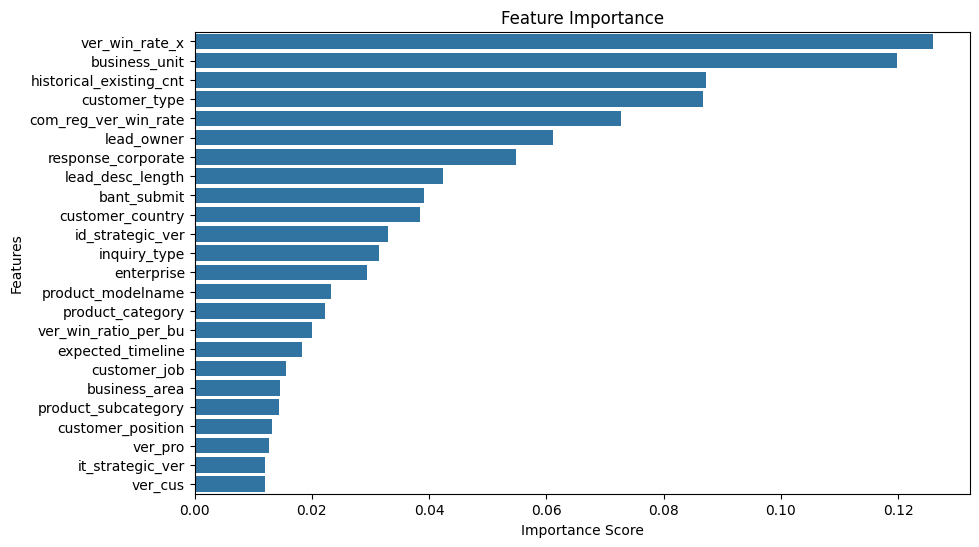

In [20]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
# XGBoost 분류기를 훈련합니다.
model = XGBClassifier()
model.fit(df_train.drop('is_converted', axis=1), df_train['is_converted'])

# Feature importance를 가져옵니다.
importances = model.feature_importances_

# Feature importance를 DataFrame으로 변환합니다.
feature_importance_df = pd.DataFrame({
    'Feature': df_train.drop('is_converted', axis=1).columns,
    'Importance': importances
})

# Feature importance를 중요도 순으로 정렬합니다.
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)
# 중요도가 높은 피처를 시각화합니다.
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



### 2-2. 학습, 검증 데이터 분리

#### tomek links

In [21]:
'''
# 수치형 컬럼의 NaN 값을 평균으로 대체
# 수치형 컬럼을 식별합니다.
numeric_columns = list(set(df_train.columns) - set(label_columns))

for col in numeric_columns:
    if df_train[col].isnull().any():
        df_train[col].fillna(df_train[col].mean(), inplace=True)
categorical_features_indices=[]
# 범주형 컬럼의 NaN 값을 가장 빈번한 값으로 대체
for col in label_columns:
    if df_train[col].isnull().any():
        df_train[col].fillna(df_train[col].mode()[0], inplace=True)
    categorical_features_indices=df_train.columns.get_loc(col)
    
'''

'\n# 수치형 컬럼의 NaN 값을 평균으로 대체\n# 수치형 컬럼을 식별합니다.\nnumeric_columns = list(set(df_train.columns) - set(label_columns))\n\nfor col in numeric_columns:\n    if df_train[col].isnull().any():\n        df_train[col].fillna(df_train[col].mean(), inplace=True)\ncategorical_features_indices=[]\n# 범주형 컬럼의 NaN 값을 가장 빈번한 값으로 대체\nfor col in label_columns:\n    if df_train[col].isnull().any():\n        df_train[col].fillna(df_train[col].mode()[0], inplace=True)\n    categorical_features_indices=df_train.columns.get_loc(col)\n    \n'

In [22]:

# TRUE와 FALSE 개수 세기
true_count = df_train['is_converted'].sum()
false_count = len(df_train) - true_count

# 두 개수 중 작은 값으로 데이터를 분할
min_count = min(true_count, false_count)

# TRUE와 FALSE 개수를 맞추어 데이터를 분할
true_data = df_train[df_train['is_converted'] == True].sample(n=min_count, random_state=400)
false_data = df_train[df_train['is_converted'] == False].sample(n=min_count, random_state=400)

# 데이터를 결합
df_balanced = pd.concat([true_data, false_data])

# val set을 먼저 구성
val_size = int(len(df_balanced) * 0.2)  # 전체 데이터의 20%를 val set으로 사용
val_set = df_balanced.sample(n=val_size, random_state=400)

# val_set을 x_val과 y_val로 분리
x_val = val_set.drop("is_converted", axis=1)
y_val = val_set["is_converted"]

# train set 구성 (비율을 맞추기 전의 데이터 사용)
train_set = df_train.drop(val_set.index)

# train set과 val set 구성 확인
print("Train set:")
print(train_set['is_converted'].value_counts())
print("Validation set:")
print(val_set['is_converted'].value_counts())


Train set:
False    50245
True      3687
Name: is_converted, dtype: int64
Validation set:
True     933
False    915
Name: is_converted, dtype: int64


In [23]:

from imblearn.under_sampling import TomekLinks, RandomUnderSampler
import pandas as pd


# Tomek Link를 적용하여 데이터 보정
tl = TomekLinks()
x_train_resampled, y_train_resampled = tl.fit_resample(train_set.drop("is_converted", axis=1), train_set["is_converted"])

# 클래스 비율 맞추기
rus = RandomUnderSampler(sampling_strategy={0: int(y_train_resampled.sum() * 1), 1: y_train_resampled.sum()}, random_state=42)
x_train, y_train = rus.fit_resample(x_train_resampled, y_train_resampled)

# 결과 확인
print("Train set after Tomek Links and balancing classes:")
print(pd.Series(y_train).value_counts())


Train set after Tomek Links and balancing classes:
False    3687
True     3687
Name: is_converted, dtype: int64


In [24]:
# x_train, x_val, y_train, y_val = train_test_split(
#     df_train.drop("is_converted", axis=1),
#     df_train["is_converted"],
#     test_size=0.2,
#     shuffle=True,
#     random_state=400,
# )

## 3. 모델 학습

### 모델 정의 

In [25]:

#!pip install shap
#model = DecisionTreeClassifier()
#model = DecisionTreeClassifier(max_depth=12, min_samples_split=3, min_samples_leaf=5)
#model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2)
true_count = sum(df_train['is_converted'] == True)
false_count = sum(df_train['is_converted'] == False)
scale_pos_weight = false_count / true_count
#scale_pos_weight=scale_pos_weight*0.5
# XGBoost 모델 초기화
model = XGBClassifier()


model_param_grid = {
    'n_estimators': [100, 150,200],
    'learning_rate': [0.1, 0.15, 0.2, 0.3],
    'max_depth': [6, 8, 10, 12]
}

model_grid=GridSearchCV(model, param_grid = model_param_grid, scoring="accuracy", n_jobs=-1, verbose = 1)
model_grid.fit(x_train, y_train)
model = model_grid.best_estimator_
model.fit(x_train, y_train) 

# import shap


# # SHAP 값을 계산하기 위한 Explainer 생성
# explainer = shap.Explainer(model, x_train)
# x_test = df_test.drop(["is_converted", "id"], axis=1)
# # 테스트 세트에 대한 SHAP 값 계산
# shap_values = explainer(x_test)

# # SHAP 요약 플롯
# shap.summary_plot(shap_values, x_test)

# # 특정 인스턴스에 대한 SHAP 값 시각화 (예: 테스트 세트의 첫 번째 인스턴스)
# shap.waterfall_plot(explainer.expected_value, shap_values[0].values, feature_names=x_test.columns.tolist())


Fitting 5 folds for each of 48 candidates, totalling 240 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 모델 학습

In [26]:
model.fit(x_train.fillna(0), y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 모델 성능 보기

In [27]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, pred)
    TP = confusion[1][1]
    FP = confusion[0][1]
    TN = confusion[0][0]
    FN = confusion[1][0]
    print(f"True Positive(TP): {TP}, False Positive(FP): {FP}, True Negative(TN): {TN}, False Negative(FN): {FN}")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [28]:
#pred = model.predict(x_val_selected_features.fillna(0))
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)
print(type(model))
#print("트리의 최대 깊이:", model.tree_.max_depth)


True Positive(TP): 860, False Positive(FP): 114, True Negative(TN): 801, False Negative(FN): 73
오차행렬:
 [[801 114]
 [ 73 860]]

정확도: 0.8988
정밀도: 0.8830
재현율: 0.9218
F1: 0.9019
<class 'xgboost.sklearn.XGBClassifier'>


## 4. 제출하기

### 테스트 데이터 예측

In [29]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [30]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

2094

### 제출 파일 작성

In [31]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

#in vscode gitignore issue

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**